## 7.7 더 깊은 신경망

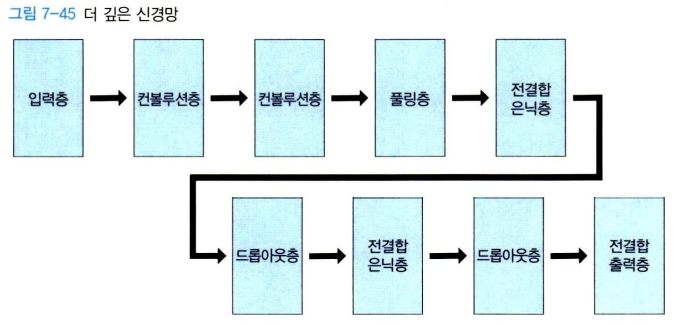

* 컨볼루션층의 활성화 함수 : ReLU
* 은닉층의 활성화 함수 : ReLU
* 출력층의 활성화 함수 : 소프트맥수 함수
* 손실함수 : 교차 엔트로피 오차
* 최적화 알고리즘 : 아다그라드
* 배치 사이즈 : 8

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- 손글씨 숫자 데이터 불러오기 --
digits_data = datasets.load_digits()
input_data = digits_data.data
correct = digits_data.target
n_data = len(correct)

# -- 입력 데이터 표준화 --
ave_input = np.average(input_data)
std_input = np.std(input_data)
input_data = (input_data - ave_input) / std_input

# -- 정답을 원-핫 인코딩으로 표현  --
correct_data = np.zeros((n_data, 10))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

# -- 훈련데이터와 테스트데이터 --
index = np.arange(n_data)
index_train = index[index%3 != 0]
index_test = index[index%3 == 0]

input_train = input_data[index_train, :]  # 훈련 데이터 입력
correct_train = correct_data[index_train, :]  # 훈련 데이터 정답
input_test = input_data[index_test, :]  # 테스트 데이터 입력
correct_test = correct_data[index_test, :]  #  테스트 데이터 정답

n_train = input_train.shape[0]  # 훈련데이터 샘플 수 
n_test = input_test.shape[0]  # 테스트 데이터 샘플 수

In [2]:
print(n_train)
print(n_test)

1198
599


In [3]:
# -- 각 설정값 --
img_h = 8  # 입력 이미지 높이
img_w = 8  # 입력 이미지 너비
img_ch = 1  # 입력 이미지 채널 수

wb_width = 0.1  # 가중치와 편향 설정을 위한 정규분포 표준편차
eta = 0.01  # 학습률
epoch = 50
batch_size = 8
interval = 10  # 경과 표시 간격
n_sample = 200  # 오차 계산 샘플 수

In [4]:
# -- im2col --
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
   
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0,0), (0,0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))

    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]

    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

# -- col2im --
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
 
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w, ).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]

    return images[:, :, pad:img_h+pad, pad:img_w+pad]

In [5]:
# -- 컨볼루션 층 --
class ConvLayer:
    
    # n_bt: 배치 사이즈, x_ch:입력 채널 수, x_h:입력 이미지 높이, x_w:입력 이미지 너비
    # n_flt:필터 수, flt_h:필터 높이, flt_w:필터 너비
    # stride:스트라이드 너비, pad:패딩 너비
    # y_ch:출력 채널 수, y_h:출력 높이, y_w:출력 너비
    
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):

        # 파라미터 정리
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        # 필터와 편향 초기값
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        # 출력 이미지 크기
        self.y_ch = n_flt  # 출력 채널 수
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1  # 출력 높이
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1  # 출력 너비
 
        # AdaGrad
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 입력이미지와 필터를 행렬로 변환
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
        
        # 출력 계산: 행렬곱、편향 더하기, 활성화 함수
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, 0, self.u)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # delta
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
        
        # 필터와 편향 기울기
        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)
        
        # 입력 기울기
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
# --  -- 풀링층 -- --
class PoolingLayer:
    
    # n_bt:배차 사이즈, x_ch:입력 채널 수, x_h:입력 이미지 높이, x_w:입력 이미지 너비
    # pool:풀링 영역 크기, pad:패딩 너비
    # y_ch:출력 채널 수, y_h:출력 높이, y_w:출력 너비
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        
        # 파라미터 정리
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        # 출력 이미지 크기
        self.y_ch = x_ch  # 출력 채널 수
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1  # 출력 높이
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1  # 출력 너비
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 입력 이미지를 행렬로 변환
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        # 출력 계산: 맥스풀링
        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
        
        # 최대값 인덱스 저장
        self.max_index = np.argmax(cols, axis=1)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 출력 기울기의 축 변경
        grad_y = grad_y.transpose(0, 2, 3, 1)
        
        # 행렬을 생성하고、각 열의 최대값이 있던 위치에 출력 기울기 입력
        grad_cols = np.zeros((pool*pool, grad_y.size))
        grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1) 
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5,0,1,2,3,4) 
        grad_cols = grad_cols.reshape( y_ch*pool*pool, n_bt*y_h*y_w)

        # 입력 기울기
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

In [6]:
# -- 전결합층의 부모 클래스 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros(( n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
# -- 전결합 은닉층 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

# -- 전결합 출력층 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1)

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

# -- 드롭아웃 --
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio

    def forward(self, x, is_train):        
        if is_train:
            rand = np.random.rand(*x.shape)
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = (1-self.dropout_ratio)*x
        
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout

In [7]:
# -- 각 층의 초기화 --
cl_1 = ConvLayer(img_ch, img_h, img_w, 10, 3, 3, 1, 1)
cl_2 = ConvLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 10, 3, 3, 1, 1)
## -> 컨볼루션층에서 이미지가 더 축소되는 것을 방지
pl_1 = PoolingLayer(cl_2.y_ch, cl_2.y_h, cl_2.y_w, 2, 0)

n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w
ml_1 = MiddleLayer(n_fc_in, 200)
dr_1 = Dropout(0.5)

ml_2 = MiddleLayer(200, 200)
dr_2 = Dropout(0.5)

ol_1 = OutputLayer(200, 10)

# -- 순전파 --
def forward_propagation(x, is_train):
    n_bt = x.shape[0]
    
    images = x.reshape(n_bt, img_ch, img_h, img_w)
    cl_1.forward(images)
    cl_2.forward(cl_1.y)
    pl_1.forward(cl_2.y)
    
    fc_input = pl_1.y.reshape(n_bt, -1)       
    ml_1.forward(fc_input)
    dr_1.forward(ml_1.y, is_train)
    ml_2.forward(dr_1.y)
    dr_2.forward(ml_2.y, is_train)
    ol_1.forward(dr_2.y)

# --역전파 --
def backpropagation(t):
    n_bt = t.shape[0]

    ol_1.backward(t)
    dr_2.backward(ol_1.grad_x)
    ml_2.backward(dr_2.grad_x)
    dr_1.backward(ml_2.grad_x)
    ml_1.backward(dr_1.grad_x)
    
    grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_2.backward(pl_1.grad_x)
    cl_1.backward(cl_2.grad_x)

# -- 가중치화 편향 수정 --
def uppdate_wb():
    cl_1.update(eta)
    cl_2.update(eta)
    ml_1.update(eta)
    ml_2.update(eta)
    ol_1.update(eta)

# -- 오차 계산 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size # 교차엔트로피 오차

# -- 샘플을 순전파 --
def forward_sample(inp, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand) 
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x, False)
    return x, t

In [8]:
# -- 오차 기록용 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 학습 경과 기록--
n_batch = n_train // batch_size
for i in range(epoch):

    # -- 오차 측정 -- 
    x, t = forward_sample(input_train, correct_train, n_sample)
    error_train = get_error(t, n_sample)
    
    x, t = forward_sample(input_test, correct_test, n_sample) 
    error_test = get_error(t, n_sample)
    
    # -- 오차 기록 -- 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    
    # -- 경과 표시 --
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))
    
    # -- 학습 -- 
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)   
    for j in range(n_batch):
        
        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]

        forward_propagation(x, True)
        backpropagation(t)        
        uppdate_wb() 

Epoch:0/50 Error_train:2.3126337652842612 Error_test:2.315315958157576
Epoch:10/50 Error_train:0.07223958172564136 Error_test:0.08330719355082138
Epoch:20/50 Error_train:0.02947008699969167 Error_test:0.05443448406867683
Epoch:30/50 Error_train:0.013080284447287815 Error_test:0.03715238466805662
Epoch:40/50 Error_train:0.006905912237822811 Error_test:0.05189238907109111


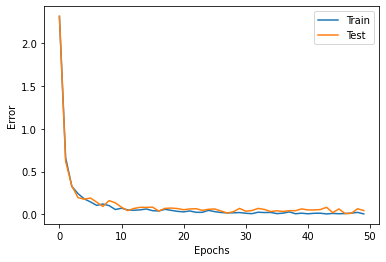

Accuracy Train: 99.91652754590984% Accuracy Test: 98.8313856427379%


In [9]:
# -- 오차 기록을 그래프로 표시 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 정답률 측정 -- 
x, t = forward_sample(input_train, correct_train, n_train) 
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

x, t = forward_sample(input_test, correct_test, n_test) 
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")

> 심한 과적합이 발생하지 않음 -> 신경망이 깊어져도 문제없이 학습해 나간다.

> 테스트 데이터의 정답률 향상 -> 인식의 정확도 향상에 효과가 있다.